# Understanding sampling and spatial resolution of a system
The first term we have to understand is sampling. We can defined sampling the spatial or temporal interval between two measurments.
The spatial resolution of a system it's one of the most important and debated parameters. 
The resolution is generally defined as the capability of resolving two adiacent peaks or signal. But this is quite a rectrictive definition and in this tutorial we will try to use a definition that encompass all the examples we will see.
We define the resolution of a system as a function that defined for each measurement element (e.g. pixel) the contribution of nearby surrounding on the measurment. In other words, we are trying to undestand the region that we are measuring and the function we are using to sampling the region. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.fftpack
from skimage.transform import rescale, resize, downscale_local_mean
from itertools import cycle

We first define our signal having or maximum or minimum values (1,0), and we create a signal with pairs of equal lenght of zeros and ones, the first pair will be 1,0, the second 1,1,0,0 and so on increasing the width of the step one by one.   
We have to think this as a completly abstract signal for the moment.

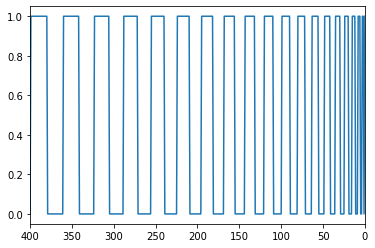

In [3]:
linear_signal = []
minima = []
maxima = []
number_of_linepairs=20
starting_width = 1
for step in range(1,number_of_linepairs+1):
    # we track the posision of the position of the maxima and the minima
    minima.append(len(linear_signal)+step*starting_width*1.5)
    maxima.append(len(linear_signal)+step*starting_width*0.5)
    # we add ones and zeros depending on the width
    linear_signal += [1]*step*starting_width + [0]*step*starting_width

# we invert the axis!
plt.xlim(400,0)
plt.plot(linear_signal)

In case of imaging systems we have this signal in a 2D-array. So we create a 2D array stacking 100 of the signal that we generated using the previous algorithm 

In [4]:
ideal = np.array(linear_signal*100).reshape(100,len(linear_signal)).astype(np.float)

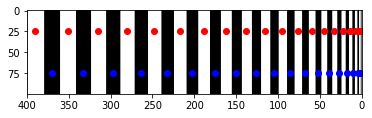

In [5]:
plt.imshow(ideal,cmap='gray')
plt.xlim(400,0)
plt.scatter(minima,np.full(len(minima),75),color='b')
plt.scatter(maxima,np.full(len(maxima),25),color='r')

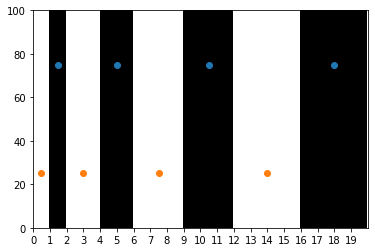

In [6]:
plt.pcolormesh(ideal,cmap='gray')
plt.scatter(minima,np.full(len(minima),75))
plt.scatter(maxima,np.full(len(maxima),25))
plt.xlim(0,20)
plt.xticks(range(20));

We define the **Cycles/Pixel** (some times found as C/P) as the cycle (pair of black and white stripe) we have for pixel. In this case we need two pixel for  describing the first cycle hence we will have (1/2) 0.5 cyles per Pixel (which correspond to the **Nyquist frequency**). For the second cycle we need four pixels. Hence we have (1/4) 0.25 cycles/pixel and so on. Generalizing:
$$  Cycles/Pixel = \frac{1}{Pixels} $$

Where Pixels are the pixels needed for describing the cycle.

We can use the contrast for evaluating the spatial resolution. In the case we calculate the contrast simply subtracting from the value registered at the centroid of the white band and the value registered at the centroid of the white band. We normalize dividing by the sum of the maximum and the minimum (this is called **Michelson contrast**):
$$ \frac{I_{max} -I_{min}}{I_{max} + I_{min}}$$

Text(0, 0.5, 'Contrast')

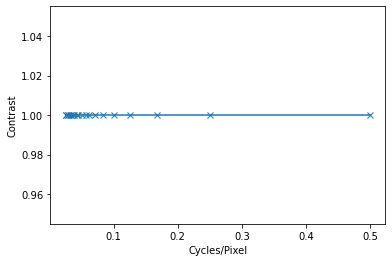

In [7]:
CyclesPixels = [round(1/(i*2),3) for i in range(1,number_of_linepairs+1)]

maxima_ind = np.array(maxima).astype(int)
minima_ind = np.array(minima).astype(int)
# we compute the contrast using the indexes of the maxima and mininma we found previously
contrast = (ideal[:,maxima_ind] - ideal[:,minima_ind])/(ideal[:,maxima_ind] + ideal[:,minima_ind])
plt.plot(CyclesPixels, contrast[0],marker='x')
plt.xlabel('Cycles/Pixel')
plt.ylabel('Contrast')


As we expected we have maximum contrast everywhere. Now try to create a signal with bands at 25 and 75%. And calculate the contrast.

(400.0, 0.0)

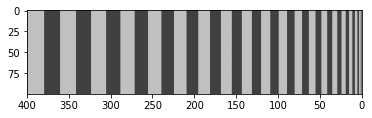

In [8]:
ideal_gray = (ideal+0.5)*0.5 # create a signal with minima at 0.25 and maxima at 0.75.
plt.imshow(ideal_gray,cmap='gray',vmin=0,vmax=1)
plt.xlim(400,0)

Text(0, 0.5, 'Contrast')

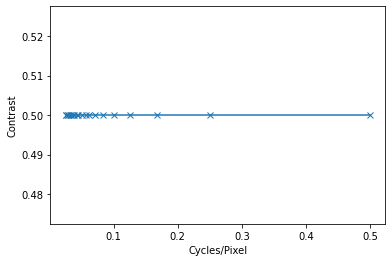

In [9]:
contrast = (ideal_gray[:,maxima_ind] - ideal_gray[:,minima_ind])/(ideal_gray[:,maxima_ind] + ideal_gray[:,minima_ind])
plt.plot(CyclesPixels, contrast[0],marker='x')
plt.xlabel('Cycles/Pixel')
plt.ylabel('Contrast')

In this case we observe that the contrast it's steady for all the frequency at fifty percent. Now we try to blur our first signal for experimenting how this affect the contrast. We use a blurring filter with a kernel of 10 by 10 pixels. 

(425.0, 0.0)

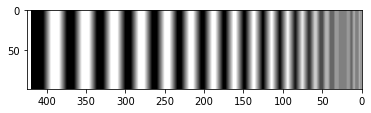

In [10]:
kernel_size = (10,10)
# we use a simple kernel 
kernel = np.ones(kernel_size)/np.sum(np.ones(kernel_size))
acquired_image = ndimage.convolve(ideal,kernel)
plt.imshow(acquired_image,cmap='gray')
plt.xlim(425,0)

(425.0, 0.0)

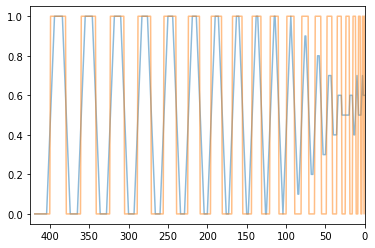

In [11]:
plt.plot(acquired_image[4,:],alpha=.5)
plt.plot(ideal[4,:],alpha=.5)
plt.xlim(425,0)

array([ 1.5,  2. ,  3.5,  4. ,  5.5,  6. ,  7.5,  8. ,  9.5, 10. , 11.5,
       12. , 13.5, 14. , 15.5, 16. , 17.5, 18. , 19.5, 20. ])

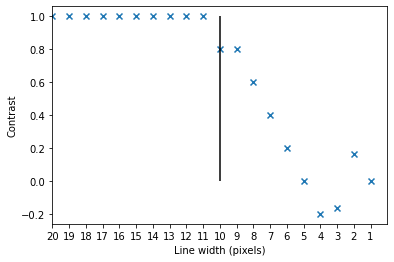

In [12]:
contrast_acquired = (acquired_image[:,maxima_ind] - acquired_image[:,minima_ind])/(acquired_image[:,maxima_ind] + acquired_image[:,minima_ind])
line_width = range(1,number_of_linepairs+1)
wavelength = np.array(minima) -np.array(maxima_ind)
plt.scatter(line_width,contrast_acquired[0],marker='x')
plt.vlines(kernel_size[0],0,1)
plt.xlim(20,0)
plt.xlabel('Line width (pixels)')
plt.ylabel('Contrast')
plt.xticks(line_width)
wavelength

Text(0, 0.5, 'Contrast')

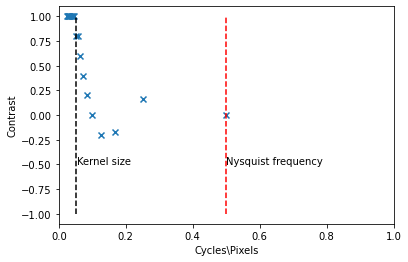

In [13]:
plt.scatter(CyclesPixels,contrast_acquired[0],marker='x')
# note now for reporting the kernel size we use 0.5/kernel_size 
plt.vlines(0.5/kernel_size[0],-1,1,linestyle='--')
plt.text(0.5/kernel_size[0]*1.1,-0.5,'Kernel size',)
plt.vlines(0.5,-1,1,linestyle='--',color='r')
plt.text(0.5,-0.5,'Nysquist frequency',)

plt.xlim(0,1)
plt.xlabel('Cycles\Pixels')
plt.ylabel('Contrast')

As you can see there are some drewbacks of this method: it requires a perfect square wave pattern which can have a considerable area, at high-frequency artefacts occurs due to the "cross contamination" of the signals.



# Knife-edge
For a first example, we imagine to be able to create a perfect "knife-edge" i.e. an element that is straight and parallel to a background. One of the first works using this techqniue  "F. Scott, R. M. Scott, and R. V. Shack, “The use of edge gradients in determining modulation transfer functions,” Photogr. Sci. Eng. 7,64–68 (1963)".

In [14]:
knife_edge = np.zeros((180,180))
knife_edge[:,90:] = 1
knife_edge[10][10]

0.0

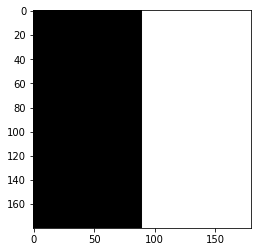

In [15]:
plt.imshow(knife_edge,cmap='gray')

If we plot a line (or an average of the lines ) of the knife edge we have the **edge response**.

Text(0.5, 1.0, 'Edge response')

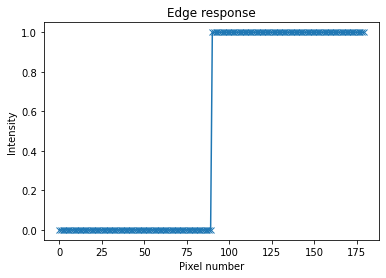

In [16]:
ideal_profile = knife_edge[5,:]
plt.plot(ideal_profile,marker='x')
plt.ylabel('Intensity')
plt.xlabel('Pixel number')
plt.title('Edge response')

The edge response of a "pure" knife edge has no intermadiate values between the min and max values. When we apply the blur as done before we obtain instead a series of intermediate values.

0.0

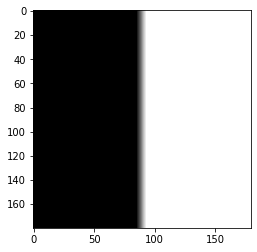

In [17]:
size = (8,8)
import scipy.stats as st

def gkern(kernlen=8, nsig=3):
    """Returns a 2D Gaussian kernel. https://stackoverflow.com/a/29731818/2132157"""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()
# we can also use gaussian kernel if we want
# kernel = gkern()

kernel = np.ones(size)/np.sum(np.ones(size))
acquired_image = ndimage.convolve(knife_edge,kernel)
plt.imshow(acquired_image,cmap='gray')
acquired_image[10][10] 

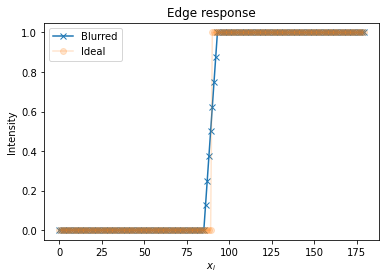

In [18]:
blurred_profile = np.mean(acquired_image,axis=0)
plt.plot(blurred_profile,marker='x',label='Blurred')
plt.plot(ideal_profile,marker='o',alpha=0.2,label='Ideal')

plt.title('Edge response')
plt.ylabel('Intensity')
plt.xlabel('$x_{i}$')
plt.legend()

(80.0, 100.0)

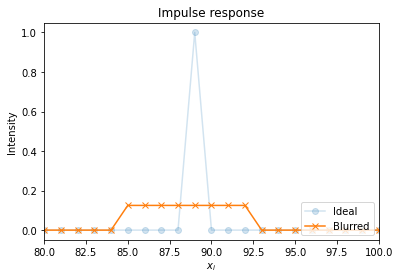

In [19]:
derivative_blurred = np.diff(blurred_profile)
derivative_ideal = np.diff(ideal_profile)

plt.plot(derivative_ideal,marker='o',alpha=0.2,label='Ideal')
plt.plot(derivative_blurred,marker='x',label='Blurred')
plt.title('Impulse response')
plt.ylabel('Intensity')
plt.xlabel('$x_{i}$')
plt.legend(loc='lower right')
plt.xlim(80,100)

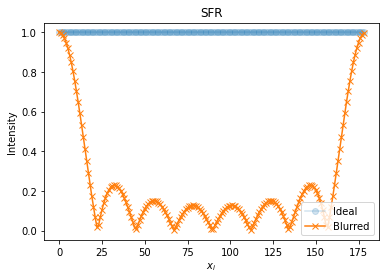

In [20]:
# Calculations
fft_blurred = np.abs(np.fft.fft(derivative_blurred))
fft_ideal = np.abs(np.fft.fft(derivative_ideal))
# Plot
plt.plot(fft_ideal,marker='o',alpha=0.2,label='Ideal')
plt.plot(fft_blurred,marker='x',label='Blurred')
plt.title('SFR')
plt.ylabel('Intensity')
plt.xlabel('$x_{i}$')
plt.legend(loc='lower right')

## A simple procedure for calculating a pseudo-Spatial Frequency Response
To recap, the generic main steps can be henced wrapped in a simple procedure. We will see later the limitations.

In [21]:
def computesSFR(knife_edgeimg):
    # we compute the mean to get a single line
    ESF = np.mean(knife_edgeimg,axis=0)
    # we compute the derivative
    LSF = np.diff(ESF)
    # we compute the fourirer transform
    SFR = np.abs(np.fft.fft(LSF))
    return SFR    

Text(0.5, 0, '$x_{i}$')

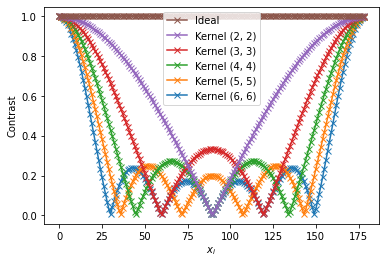

In [22]:
sizes = [(6,6),(5,5),(4,4),(3,3),(2,2),(1,1)]
fig,ax = plt.subplots()
for size in sizes:
    kernel = np.ones(size)/np.sum(np.ones(size))
    # we blurr each image excpet the first (blurred with 1 by 1 Kernel)
    blurred_image = ndimage.convolve(knife_edge,kernel)
    # we compute the SFR for each blurred image 
    SFR = computesSFR(blurred_image) # 
    ax.plot(SFR,marker='x',label='Kernel %s' %str(size))
handles, labels = ax.get_legend_handles_labels()
labels[-1] = 'Ideal'
ax.legend(reversed(handles), reversed(labels))
plt.ylabel('Contrast')
plt.xlabel('$x_{i}$')

In [23]:
%matplotlib inline
from ipywidgets import interactive

ESF_ideal = np.mean(knife_edge,axis=0)
def plot_f(kernel_size):
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(141)
    size = (kernel_size,kernel_size)
    kernel = np.ones(size)/np.sum(np.ones(size))
    # we blurr each image excpet the first (blurred with 1 by 1 Kernel)
    blurred_image = ndimage.convolve(knife_edge,kernel)
    ax1.imshow(blurred_image,cmap='gray')
    ax1.set_title('Image')
    ax2 = fig.add_subplot(142)
    ESF = np.mean(blurred_image,axis=0)
    ax2.plot(ESF)
    ax2.plot(ESF_ideal,linestyle='--',label='Ideal')
    ax2.set_title('Edge Spread Function')
    ax2.annotate("", xy=(90-kernel_size/2,0.5), xytext=(90+kernel_size/2,0.5),arrowprops=dict(arrowstyle="<->"))
    ax2.legend()
    ax3 = fig.add_subplot(143)
    LSF = np.diff(ESF)
    ax3.plot(LSF)
    maxx = np.max(LSF)/2
    ax3.annotate("", xy=(89+kernel_size/2,maxx),
                 xytext=(89-kernel_size/2,maxx),
                 arrowprops=dict(arrowstyle="<->"))
    ax3.set_title('Line Spread Function (LSF)')
    ax4 = fig.add_subplot(144)
    SFR = np.abs(np.fft.fft(LSF))
    ax4.plot(SFR,marker='x')
    #ax4.vlines(kernel_size,-1,2,linestyle='--',alpha=0.5)
    ax4.set_ylim(-0.1,1.2)
    ax4.set_title('pseudo-Spatial Frequency Response (SFR)')
    
interactive_plot = interactive(plot_f, kernel_size=(1, 30))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=15, description='kernel_size', max=30, min=1), Output(layout=Layout(heig…



## Phase influence on the measurment
Up to now we dealt with pure abstract signals. Now we try to get closer to the reality taking into account the various component of the imaging system. We start adding the sensor in this case we imagine the sensor as for instance a monochrome CCD array with pixel.

The image is projected on the surface of the sensor (let say on an area of 9 x 9 pixels, and each square pixel lenght is 20 microns). As shown in the figure below: 

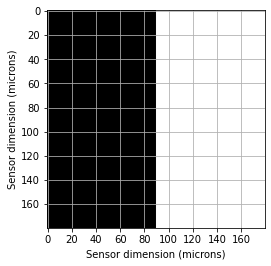

In [24]:
plt.imshow(knife_edge,cmap='gray')
plt.xticks(range(0,180,20))
plt.yticks(range(0,180,20))
plt.xlabel("Sensor dimension (microns)")
plt.ylabel("Sensor dimension (microns)")
plt.grid()

Each of the pixels will integrate the signal collected on the area for returing a single voltage value. To simulate this we create a function that average the values of the light on each pixel.

We can notice that, in this case, when positioning the kinfe-edge on our imaginary set-up, **the edge of the knife-edge image** happend to be centered on the middle of fifth column of the sensor area. Hence each pixel of the column will recive half of the light that recieve the pixel on the right.


In [25]:
def simulate_CCD(inputimage,pix_l=20):
    avarage_signal = []
    area_h, area_w = inputimage.shape
    pixels_h = area_h//pix_l
    pixels_w = area_w//pix_l
    for i in range(pixels_h):
        for j in range(pixels_w):
            avarage_signal.append(np.average(inputimage[0+pix_l*i:pix_l+pix_l*i,0+pix_l*j:pix_l+pix_l*j]))
    # riformo un immagine
    return np.array(avarage_signal).reshape(pixels_h,pixels_w)

# note this is similar to downscale_local_mean(inputimage, (20,20)) from skimage.transform

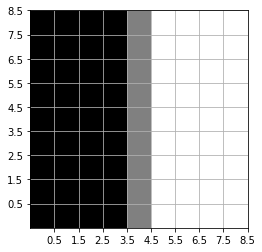

In [26]:
new_img = simulate_CCD(knife_edge)
pixels_h, pixels_w = new_img.shape
plt.imshow(new_img,cmap='gray')
# plotting
plt.xticks(np.arange(pixels_h)+0.5)
plt.yticks(np.arange(pixels_w)+0.5)
plt.xlim(-0.5,pixels_w-0.5)
plt.ylim(-0.5,pixels_h-0.5)
plt.grid()

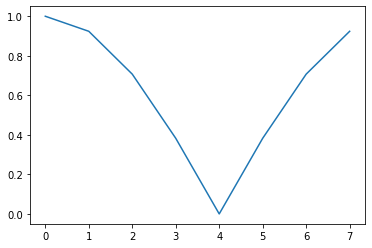

In [27]:
plt.plot(computesSFR(new_img))

Hence when we move the knife-edge along one direction we will have a different SFR.

In [28]:
%matplotlib inline
from ipywidgets import interactive
def plot_f(offset):
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(131)
    knife_edge_2 = np.zeros((180,180))
    knife_edge_2[:,offset:] = 1
    ax1.imshow(knife_edge_2,cmap='gray')
    ax1.set_title('Ideal knife-edge projected to the sensor array')
    ax1.grid()
    ax1.set_xlabel('Sensor length')
    ax1.set_ylabel('Sensor width')
    ax2 = fig.add_subplot(132)
    ax2.set_xlabel('Pixel number')
    ax2.set_ylabel('Pixel number')
    acq_img = simulate_CCD(knife_edge_2)
    ax2.imshow(acq_img,cmap='gray')
    ax2.set_title('As seen from the sensor camera') 
    ax3 = fig.add_subplot(133)
    ax3.plot(computesSFR(acq_img))
    ax3.set_title('(simple) Spatial Frequency Response (SFR)')
    ax3.set_ylim(0,1.1)
    
interactive_plot = interactive(plot_f, offset=(60, 140,2))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=100, description='offset', max=140, min=60, step=2), Output(layout=Layou…

As we can see from the plots above the output of the anlysis depends on the position of the knife-edge relative to the center of the pixel.

Hence with this method with a single analysis the resolution of the system can not be determined accurately. 
To overcome this problem we can move the knife-edge (or the camera) with steps shorter than the pixel take an image for every step and eventually create a super-sampled image.

In this case we know that the size of the pixel is 20 microns so we can move the knife edge with for steps of 5 microns to super-sample the pixel and then fuse the resulting images in a super sampled image.

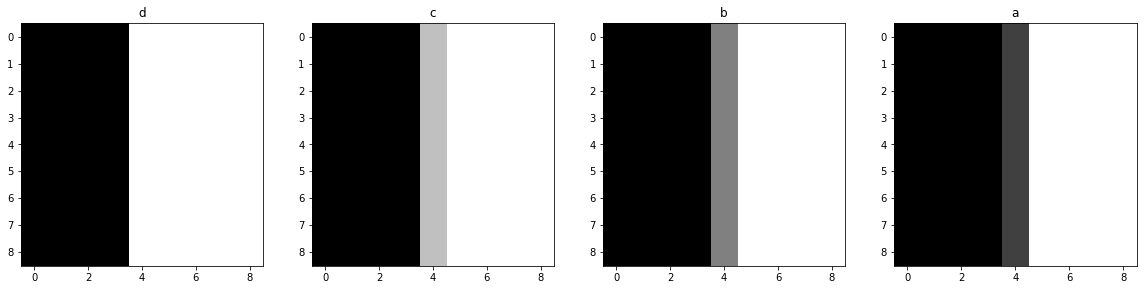

In [80]:
pxiel_length = 20 # microns
step = 5 # microns
images = []
fig = plt.figure(figsize=(20,5))
axs = {}
supersampling = pxiel_length//step
names = ['d','c','b','a']
for i in range(supersampling):
    moving_edge = np.zeros((180,180))
    moving_edge[:,80+step*i:] = 1
    img = simulate_CCD(moving_edge)
    images.append(img)
    axs[i] = fig.add_subplot(141+i)
    axs[i].imshow(img,cmap='gray')
    axs[i].set_title(names[i])


Now we can fuse the image togheter creating a supersampled image:

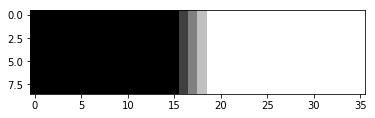

In [63]:
h, w = images[0].shape
# the column of the image a,b,c and d will be merged as shown here
#img a :  1a|  |  |  |2a|  |  |  |3a|  |  | 
#img b :    |1b|  |  |  |2b|  |  |  |3b|  |
#img c :    |  |1c|  |  |  |2c|  |  |  |3c|
#img d :    |  |  |1d|  |  |  |2d|  |  |  |3d
#result:  1a|1b|1c|1d|2a|2b|2c|2d|3a|3b|3c|3d...   <-super_sampled 
# we create an array with a "supersampeling" times greater to the original
super_sampled = np.empty((h,w*supersampling))
# we iterate over the image in a reverse order for respecting the edge direction
for ix,im in enumerate(reversed(images)):
    # we substitute every "supersampling" colum 
    # (::supersampling) with the data of the image
    super_sampled[:,ix::supersampling] = im

plt.imshow(super_sampled,cmap='gray')

In the super sample image has a different aspect-ratio because we super-sampled only the horizontal axis.

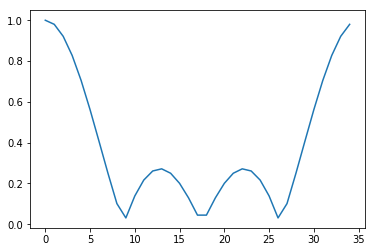

In [65]:
plt.plot(computesSFR(super_sampled))

We can notice that even if we have an ideal lens the SFR will never be a straight line of ones. 

This method has some drewback because it requires to move the knife edge with micro or nanometric precision. In the laste decades alternative and more accessible methods have been developed. The most popular is the stlanted-edge method that we will see in the following section. 

# Slanted-edge method

ISO 12233 defines a method for measuring the SFR from a slanted-edge. This method allows to create a super-sampled signal using a single image. Because we are working using array our slanted-edge will be formed by discrete steps. However, assuming that the sensor pixel is larger than the sampling used for generating the singal we can still perform valid simulation using slanted-edge rapresented by arrays.

Text(0.5, 1.0, 'Ideal but discrete slanged-edge')

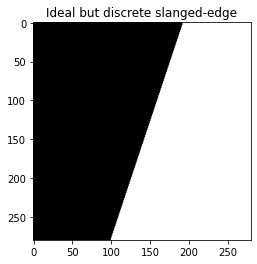

In [301]:
slanted_edge = np.zeros((280,280))
for i in range(280):
    slanted_edge[279-i,int((300+i)/3):] = 1
#plt.xticks(range(0,280,10))
#plt.yticks(range(0,280,10))
plt.imshow(slanted_edge,cmap='gray')
plt.title("Ideal but discrete slanged-edge")
#plt.grid()

We simulate the effect of our sensor using a pixel of 10 microns.

Text(0.5, 1.0, 'As seen by the sensor with ideal lens')

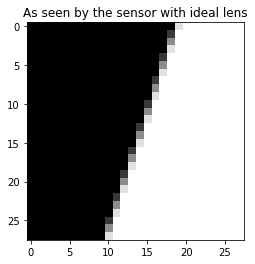

In [302]:
img_se = simulate_CCD(slanted_edge,pix_l=10)
plt.imshow(img_se,cmap='gray')
plt.title("As seen by the sensor with ideal lens")


We can add a blur for simulating the lens.

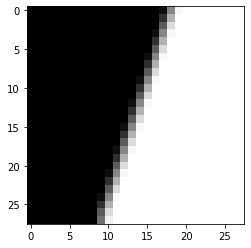

In [303]:
size = (2,2)
kernel = np.ones(size)/np.sum(np.ones(size))
img_se_b = ndimage.convolve(img_se,kernel)
plt.imshow(img_se_b,cmap='gray')

The resulting image is our test image that we will use for calculating the SFR. Now we start with a sintethic signal so we will skip some steps that we often have to perform in image taken using still digital cameras.

As in the previous example we compute everything relative to a line perpendicular to the edge. In fact, here we have approximately a representation of a moving knife-edge in a single image. Where each line represent a snapshot of a single movement.

 ## Filtering
 As we can see, the edge is usually at the center of the image we multiply each line by a hamming window of the same length for filtering the noise.

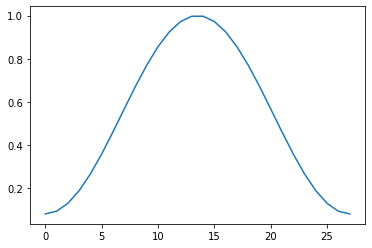

In [177]:
ham = np.hamming(img_se_b.shape[0])
plt.plot(ham)

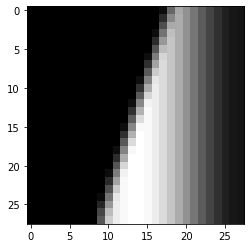

In [178]:
img_se_bh = img_se_b*ham
plt.imshow(img_se_bh,cmap='gray')

## Finding the edge
For finding the edge  different approach can be used in the Annex D a general procedure, comprising the derivation and the computation of the centroid for a singl line is the following:

In [ ]:
probfun = np.sum(np.array([(i+1)*(img_se_b[0][i+1] - img_se_b[0][i]) for i in range(len(img_se_b[0])-1)]) -0.5

This can be vectorize as follows:

378.0
[377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5
 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5 377.5
 377.5 377.5 377.5 377.5]


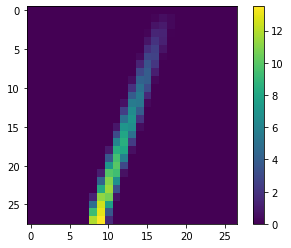

In [304]:
diff = np.diff(img_se_b,axis=1)
plt.imshow(diff*np.arange(img_se_b.shape[1])[:,None])
plt.colorbar()
print(np.sum(diff*np.arange(img_se_b.shape[1])[:,None]))
indexesprob_arr = np.sum(diff*np.arange(img_se_b.shape[1])[:,None],axis=1)/np.sum(diff,axis=1)[:,None]
indexes = np.sum(indexesprob_arr, axis = 1) -0.5
print(indexes)

Another approach for finding the edge the first step is to compute the derivative using a `[-1/2,+1/2]`  finite impulse response (FIR) filter for each row of pixels perpendicular to the edge. In this case we use second order accurate central difference.

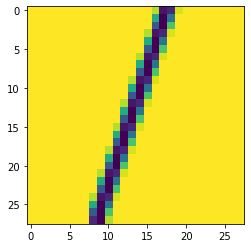

In [305]:
from scipy.ndimage import convolve1d
diff_img = convolve1d(img_se_b,[-0.5,0.5],axis=1)
plt.imshow(diff_img)

Another option not written in the ISO is use a second order accurate central difference. Which is implemented in the np.gradent function

(28, 28)


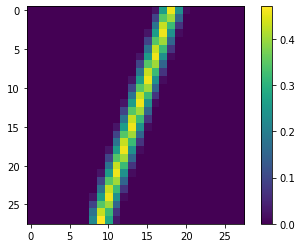

In [306]:
diff_img = np.gradient(img_se_b,axis=1)
plt.imshow(diff_img)
plt.colorbar()
print(diff_img.shape)

# Computation of the centroid
An appendix is reserved for the computation of the centroid which cosists on finding the index of the the center of the edge. This procedure can be summarized as following we find the normalized LSF along the axis perpendicular to the edge (axis 1):

In [307]:
normalized_LSF = diff_img/np.sum(diff_img,axis=1)[:,None]

Then we multiply the normalized LSF by the indexes of the axis perpendicular to the edge:

In [308]:
index_prbfun = normalized_LSF*np.arange(diff_img.shape[1])

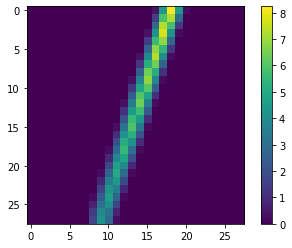

In [309]:
plt.imshow(index_prbfun)
plt.colorbar()

In [310]:
x_indexes = np.sum(index_prbfun,axis=1)

We plot the centroid found.

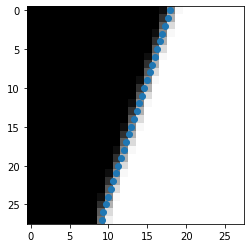

In [311]:
plt.imshow(img_se_b,cmap='gray')
row_indxes = np.arange(img_se_b.shape[0])
plt.scatter(x_indexes,row_indxes)

# Finding the best fit line
We fit a line trhoght the centroids.

In [312]:
from scipy import optimize

def straight_line(x, m, q):
    return m*x + q

params, params_covariance = optimize.curve_fit(straight_line,xdata=row_indxes,ydata=x_indexes,
                                               p0=[2, 2])
print(params)
# we then compute the new params
newpos = straight_line(row_indxes,params[0],params[1])

[-0.33206897 17.93900246]


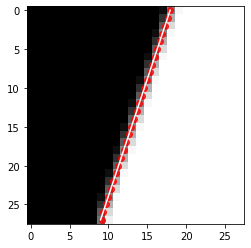

In [313]:
plt.imshow(img_se_b,cmap='gray')
plt.scatter(x_indexes,row_indxes,alpha=.8,color='r')
plt.plot(newpos,row_indxes,color='w')

# Creating the supersampeld image
Also here there are two main difference in the implementation on the ISO 12233 from the 6.2.4 to the Annex D.
The 6.2.4  uses the first line as reference line and then adds the points from all the other lines in four bins around the edge point having widht of 1/4 of the pixels around the edge of each line. 

In [341]:
ref_point = x_indexes[0]
offsets = x_indexes - ref_point
print(offsets)
s
np.arange(img_se_b.shape[0]) - offsets

[ 0.    -0.335 -0.665 -1.    -1.335 -1.665 -2.    -2.335 -2.665 -3.
 -3.335 -3.665 -4.    -4.335 -4.665 -5.    -5.335 -5.665 -6.    -6.335
 -6.665 -7.    -7.335 -7.665 -8.    -8.335 -8.665 -8.83 ]


array([ 0.   ,  1.335,  2.665,  4.   ,  5.335,  6.665,  8.   ,  9.335,
       10.665, 12.   , 13.335, 14.665, 16.   , 17.335, 18.665, 20.   ,
       21.335, 22.665, 24.   , 25.335, 26.665, 28.   , 29.335, 30.665,
       32.   , 33.335, 34.665, 35.83 ])

In [287]:
# we calculate the angular coefficient
m = np.average(np.diff(newpos))/1

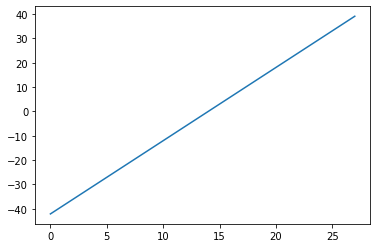

In [314]:
deviations = row_indxes*m

narr = []
for i in np.arange(img_se_b.shape[0]):
    narr.append((img_se_b.shape[0]/2 - i)/m)

plt.plot(narr)

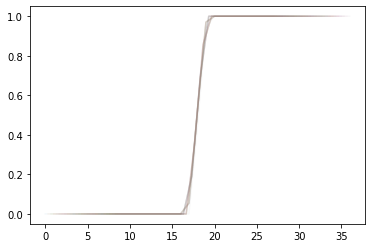

In [322]:
xarr = []
for line,dev in zip(img_se_b,deviations):
    newind = row_indxes-dev
    xarr.append(newind)
    plt.plot(newind,line,alpha=0.05)
xarr = np.array(xarr)

In [336]:
supersampled = []

for i in np.arange(0,img_se_b.shape[0],0.125):
    vals = img_se_b[np.where(np.logical_and(xarr>=-0.125+i, xarr<0.125+i))]
    supersampled.append(np.mean(vals))

/Users/giacomo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/giacomo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


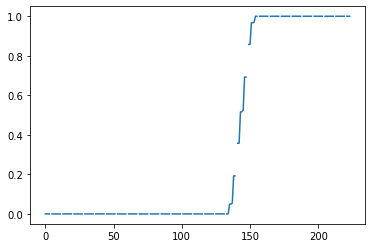

In [337]:
plt.plot(supersampled)

# Appendix A - The centroid of a line
The term centroid of a line is not very common but it is used on the ISO 12233. Here, we explain brifily how it works. The main goal of computing the centroid is to find the index of the value of the border.
Assuming we have an array of six values, where the 4th value (index five) it is an impulse, a peak of widht one:

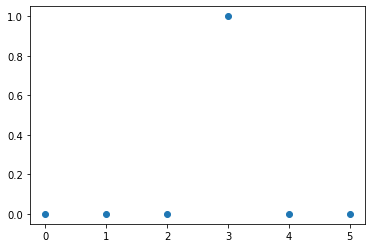

In [105]:
indexes = np.arange(6)
values = np.array([0,0,0,1,0,0])
plt.scatter(indexes,values)

It is helpful to gasp the concept to look a the values array as a probablity matrix. Where the value is higher the higher is the probability to find the peak. So a value of one in this case can be interpreted as 100% probability to find te peak. So in this case we can find the peak multiplying the indexes by the values array:

In [106]:
peak = indexes*values
print(peak)

[0 0 0 3 0 0]


We notice the index three (forth value) appearing. We could sum each element of the array to get the single index. This of course is a simple case. But if we have for instance a platou?

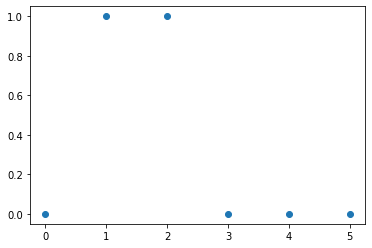

In [111]:
values = np.array([0,1,1,0,0,0])
plt.scatter(indexes,values)

We calculate the normalized probability function and then we multiply it for the indexes. We finally compute the sum:

In [112]:
probfun = values/np.sum(values)
res = indexes*probfun
print(sum(res))

1.5


2.5


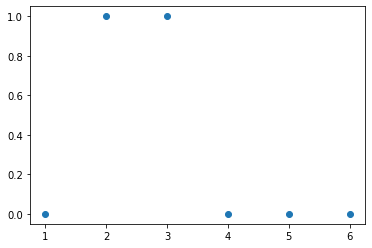

In [114]:
indexes = np.arange(1,7)
plt.scatter(indexes,values)
probfun = values/np.sum(values)
res = indexes*probfun
print(sum(res))

In [116]:
g = np.array([[2,2,0,0,0,0],
             [0,2,3,0,0,0],
             [0,0,2,3,0,0],
             [0,0,0,2,2,0],
             [0,0,0,0,3,2]])

In [125]:
gsum = np.sum(g,axis=1)

In [147]:
np.sum(g/gsum[:,None]*np.arange(6),axis=1)

array([0.5, 1.6, 2.6, 3.5, 4.4])

# Calculating SFR using auto-correlation
In this section we show an alternatve procedure for calculating the Spatial Frequency Response. This procedure was designed for a fast computations on systems with low-geometrical distortion. It replace the steps involving the edge detection and the best-line fitting using a method based on auto-correlation.

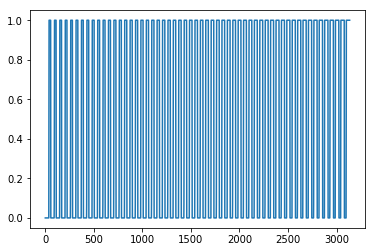

In [25]:
plt.plot(knife_edgeres.flatten())

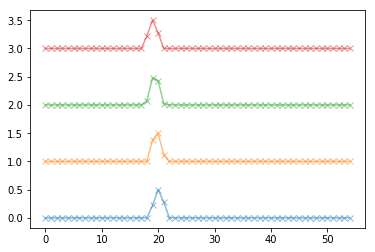

In [26]:
derivative_ideal_1 = np.diff(knife_edgeres[50])
derivative_ideal_2 = np.diff(knife_edgeres[51])
derivative_ideal_3 = np.diff(knife_edgeres[52])
derivative_ideal_4 = np.diff(knife_edgeres[53])
plt.plot(derivative_ideal_1,marker='x',alpha=0.5)
plt.plot(derivative_ideal_2+1,marker='x',alpha=0.5)
plt.plot(derivative_ideal_3+2,marker='x',alpha=0.5)
plt.plot(derivative_ideal_4+3,marker='x',alpha=0.5)

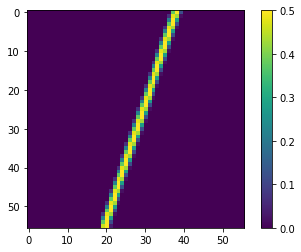

In [27]:
# new we calculate the position of the edge
# is it better to take the derivative along the x or y coordinates?
derivative = np.diff(knife_edgeres,axis=1,prepend=0)
#derivative = np.diff(knife_edgeres,axis=0)
# we add a colum on the right to get the same dimension of the original array
# or shall we consider the derivative as a value associated between two pixel hence with coordinates shifted
#derivative = np.c_[derivative,np.zeros(derivative.shape[0])]
# in case
#derivative = np.c_[derivative,np.zeros(derivative.shape[0])]
plt.imshow(derivative)
plt.colorbar()


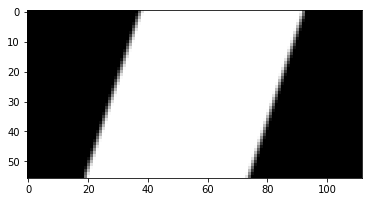

In [28]:
kinfdb = np.hstack([knife_edgeres,np.rot90(knife_edgeres,2)])
plt.imshow(kinfdb,cmap='gray')

6272


(0, 500)

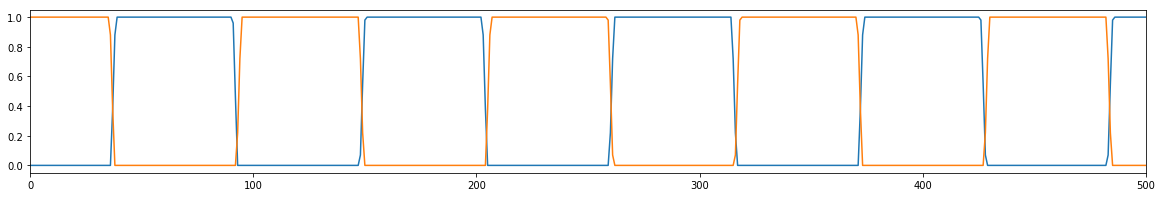

In [29]:
plt.rcParams['figure.figsize'] = (20,3)
kinfdbf = kinfdb.flatten()
print(kinfdbf.size)
plt.plot(kinfdbf[:1000])
plt.plot(kinfdbf[167:1167])
plt.xlim(0,500)

330
335
167.5


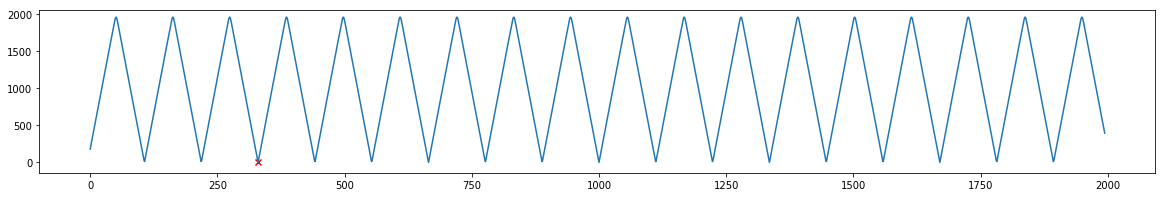

In [30]:
#results = [np.sum(np.abs(kinfd - np.roll(kinfd,i))) for i in range(1,350)]
offset = 5 # we put an offset otherwise the autocorrelation will be highest at the beginin
results2 = [np.sum(np.abs(kinfdbf[:2000] - kinfdbf[i:2000+i])) for i in range(offset,2000)]
plt.plot(results2)
plt.scatter(np.argmin(results2),np.min(results2),marker='x',color='r')
optimumautocorr = np.argmin(results2) + offset
print(np.argmin(results2))
print(optimumautocorr)
print(optimumautocorr/2)

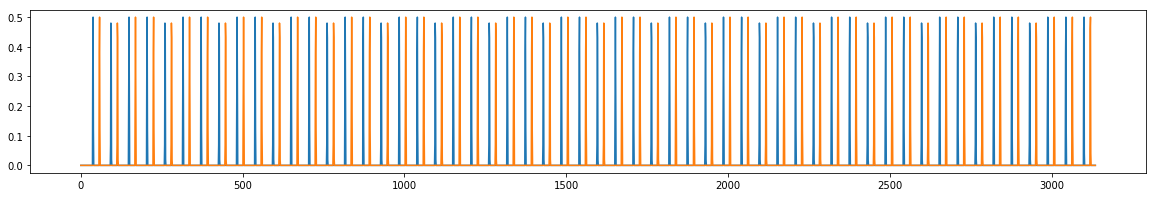

In [31]:
plt.rcParams['figure.figsize'] = (20,3)
dersig = derivative.flatten()
plt.plot(dersig)
plt.plot(np.roll(dersig,20))

In [32]:
def calculate_corr(signal,steps=None):
    if steps == None:
        steps = len(signal)/2
    return [np.sum(np.abs(signal - np.roll(signal,i))) for i in range(1,steps)]

In [33]:
results = [np.sum(np.abs(dersig - np.roll(dersig,i))) for i in range(5,850)]

162
3136
18.895705521472394


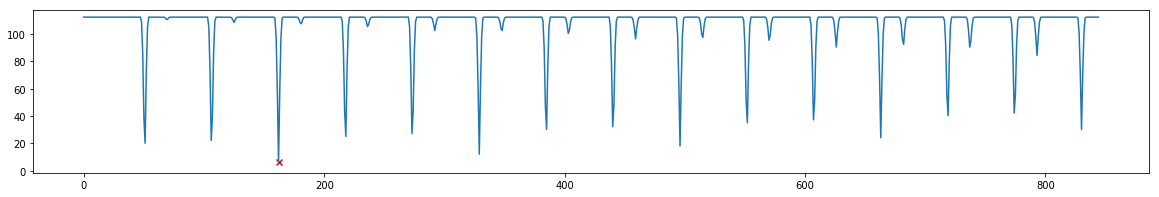

In [34]:
plt.plot(results)
plt.scatter(np.argmin(results),np.min(results),marker='x',color='r')
print(np.argmin(results))
print(derivative.size)
print(3080/163)

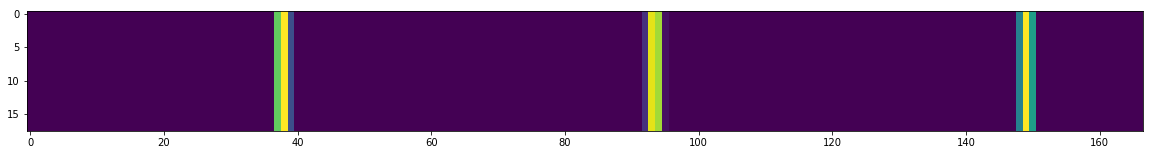

In [35]:
plt.imshow(dersig[:167*18].reshape(18,167))

(56, 56)


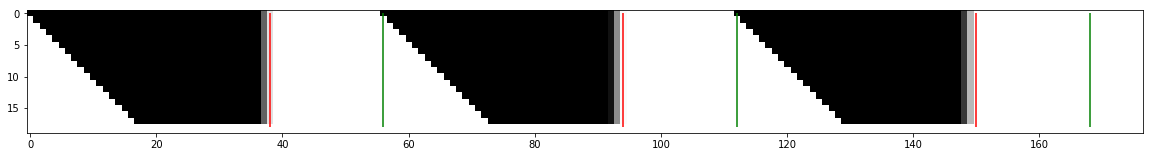

In [36]:
reformed = knife_edgeres.flatten()[:167*18].reshape(18,167)
plt.imshow(reformed,cmap='gray')
plt.vlines(x=[38,94,150],ymax=18,ymin=0,color='r')
plt.vlines(x=[56,56*2,56*3],ymax=18,ymin=0,color='g')
print(knife_edgeres.shape)

In [37]:
mean = np.mean(reformed,axis=0)
print(mean.size)
print(56*3)

print(167 - (knife_edgeres.size - 167*18))
print(3*18)

167
168
37
54


In [38]:
res = np.empty(56*3-1)
res[2::3]

array([2.16764093e-314,             nan, 6.94401903e-310, 5.96455302e-313,
       0.00000000e+000, 1.27319747e-313, 5.96455302e-313, 4.94065646e-323,
       6.94401903e-310, 5.96455302e-313, 1.28457068e-322, 3.18299369e-313,
       5.96455302e-313, 1.28457068e-322, 6.94401903e-310, 5.96455302e-313,
       9.88131292e-323, 0.00000000e+000, 5.96455302e-313, 1.28457068e-322,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 5.96455302e-313, 9.88131292e-324, 0.00000000e+000,
       0.00000000e+000, 4.44659081e-323, 4.94065646e-324, 5.96399834e-313,
       1.48219694e-323, 0.00000000e+000, 0.00000000e+000, 5.96455302e-313,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 3.95252517e-321, 6.94421351e-310,             nan,
       5.41495948e-321, 6.94421351e-310, 2.16764353e-314, 7.21478569e-313,
       6.94421351e-310, 9

In [39]:
res[::3]  = mean[:56]
res[1::3] = mean[56:56*2]
res[2::3] = mean[56*2:56*3]

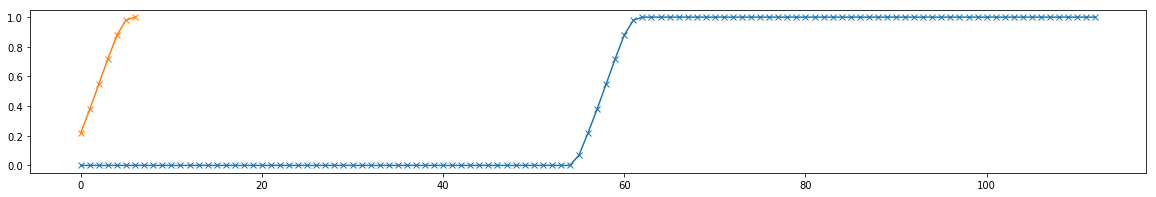

In [40]:
plt.plot(res[18*3:],marker='x') # multiply colum by 3 the number of pixel
plt.plot(res[110:-50],marker='x') # multiply colum by 3 the number of pixel

(0, 56.0)

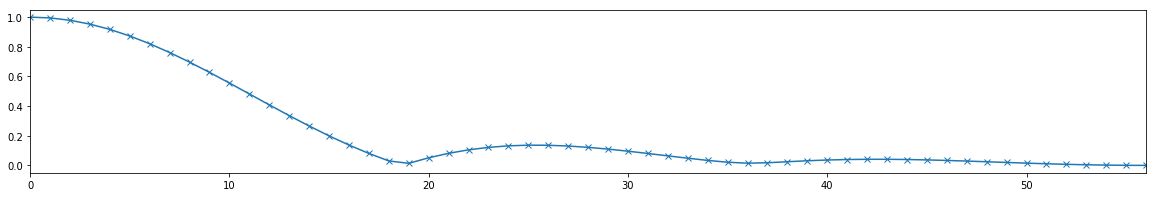

In [45]:
LSF = np.diff(res[18*3:])
absolute_offFFT = np.abs(np.fft.fft(LSF))
plt.plot(absolute_offFFT,marker='x')
# we limit to half
plt.xlim(0,len(absolute_offFFT)/2)

In [157]:
#plt.plot(np.correlate(derivative.flatten(),derivative.flatten(),mode='full')result[result.size/2:])

In [158]:
#plt.plot(np.abs(np.fft.fft(derivative.flatten())),marker='x',label='Acquired %s' %str(size))


In [159]:
maxderv = np.argmax(derivative,axis=1)
maxderv

array([39, 38, 38, 38, 37, 37, 37, 36, 36, 36, 35, 35, 35, 34, 34, 34, 33,
       33, 33, 32, 32, 32, 31, 31, 31, 30, 30, 30, 29, 29, 29, 28, 28, 28,
       27, 27, 27, 26, 26, 26, 25, 25, 25, 24, 24, 24, 23, 23, 23, 22, 22,
       22, 21, 21, 21, 21])

In [160]:
maxderv.size

56

In [93]:
imagevalues = knife_edgeres[range(knife_edgeres.shape[1]), maxderv]

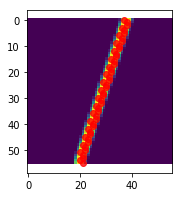

In [94]:
plt.imshow(derivative)
cols = range(derivative.shape[0])
plt.scatter(maxderv,cols,alpha=.8,color='r')

(40, 30)

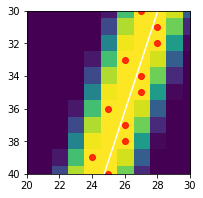

In [97]:
plt.imshow(derivative)
cols = range(derivative.shape[0])
plt.scatter(maxderv,cols,alpha=.8,color='r')
plt.plot(newpos,cols,color='w')
plt.xlim(20,30)
plt.ylim(40,30)

(40, 30)

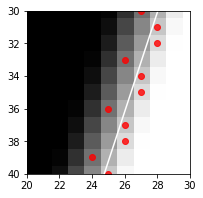

In [98]:
plt.imshow(knife_edgeres,cmap='gray')
cols = range(derivative.shape[0])
plt.scatter(maxderv,cols,alpha=.8,color='r')
plt.plot(newpos,cols,color='w')
plt.xlim(20,30)
plt.ylim(40,30)

In [99]:
newpos

array([37.89849624, 37.56971975, 37.24094327, 36.91216678, 36.58339029,
       36.25461381, 35.92583732, 35.59706083, 35.26828435, 34.93950786,
       34.61073137, 34.28195489, 33.9531784 , 33.62440191, 33.29562543,
       32.96684894, 32.63807245, 32.30929597, 31.98051948, 31.65174299,
       31.32296651, 30.99419002, 30.66541353, 30.33663705, 30.00786056,
       29.67908407, 29.35030759, 29.0215311 , 28.69275461, 28.36397813,
       28.03520164, 27.70642515, 27.37764867, 27.04887218, 26.72009569,
       26.39131921, 26.06254272, 25.73376623, 25.40498975, 25.07621326,
       24.74743677, 24.41866029, 24.0898838 , 23.76110731, 23.43233083,
       23.10355434, 22.77477785, 22.44600137, 22.11722488, 21.78844839,
       21.45967191, 21.13089542, 20.80211893, 20.47334245, 20.14456596,
       19.81578947])

In [100]:
fractional_part, int_part = np.modf(newpos)
bin1 = np.average(knife_edgeres[(fractional_part>=0)*(fractional_part<0.25)])
bin2 = np.average(knife_edgeres[(fractional_part>=0.25)*(fractional_part<0.5)])
bin3 = np.average(knife_edgeres[(fractional_part>=0.5)*(fractional_part<0.75)])
bin4 = np.average(knife_edgeres[(fractional_part>=0.75)*(fractional_part<1)])# why not include 1?!
superres = np.array([bin1,bin2,bin3,bin4])
print(superres)

[0.53989583 0.49875    0.44821429 0.47651099]


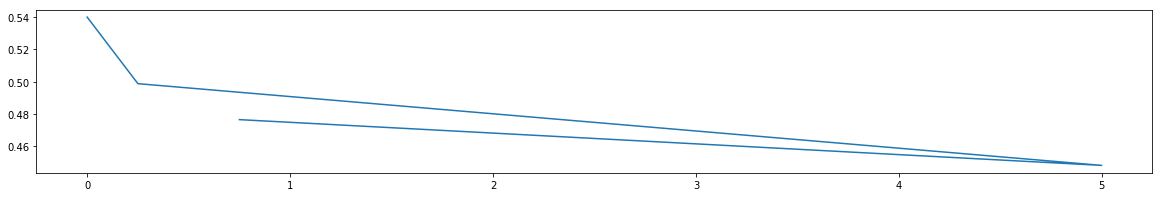

In [101]:
plt.plot([0,0.25,5,0.75],superres)

[-0.33255615 37.30019985]


(40, 30)

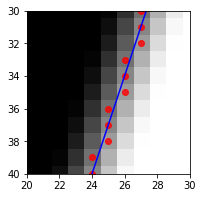

In [102]:
from skimage import feature
edges1 = feature.canny(knife_edgeres)
ys, xs = np.where(edges1)
plt.imshow(knife_edgeres,cmap='gray')
params, params_covariance = optimize.curve_fit(straight_line, ys, xs,
                                               p0=[2, 2])
print(params)
cols = range(knife_edgeres.shape[0])
# we then compute the new params
newpos = straight_line(cols,params[0],params[1])
angle_rad = np.arctan(params[0])
angle_deg = angle_rad * (180/np.pi)
plt.scatter(xs,ys,alpha=.8,color='r')
plt.plot(newpos,cols,color='b')
plt.xlim(20,30)
plt.ylim(40,30)

In [103]:
from skimage import filters
edge_sobel = filters.sobel(image_rot)
edge_scharr = filters.scharr(image_rot)
edge_prewitt = filters.prewitt(image_rot)


NameError: name 'image_rot' is not defined

# Sorting and finding uniques

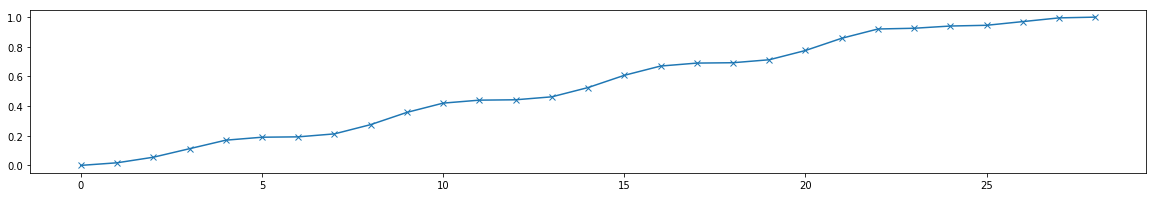

In [104]:
plt.plot(np.unique(sorted(knife_edgeres.flatten())),marker='x')

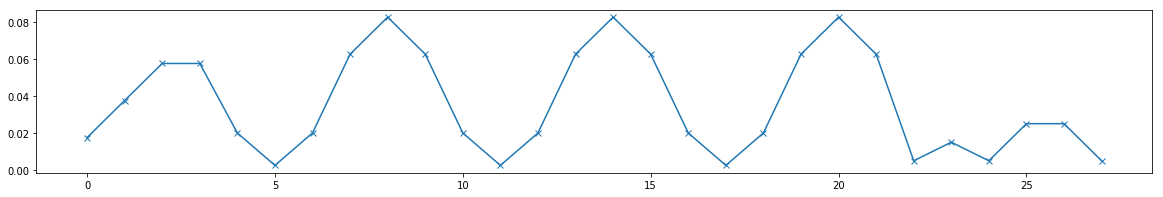

In [105]:
derivative_ideal = np.diff(np.unique(sorted(knife_edgeres.flatten())))
plt.plot(derivative_ideal,marker='x')

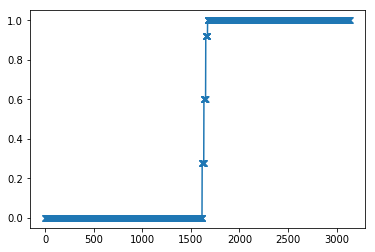

In [55]:
plt.plot(sorted(knife_edgeres.flatten()),marker='x')

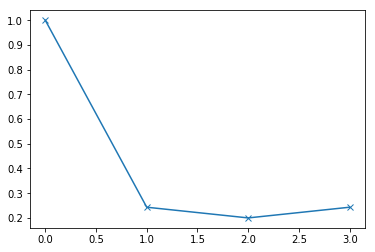

In [66]:
difedger = np.diff(np.unique(sorted(knife_edgeres.flatten())))
plt.plot(np.abs(np.fft.fft(difedger)),marker='x')


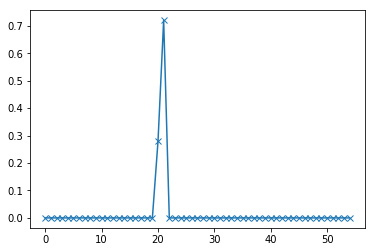

In [69]:
plt.plot(derivative_ideal,marker='x')

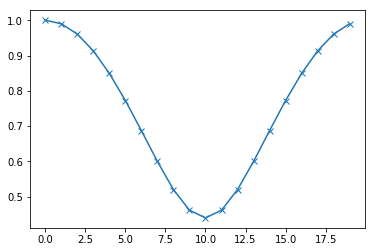

In [70]:
plt.plot(np.abs(np.fft.fft(derivative_ideal[10:30])),marker='x')

# Tests

In [ ]:
w = np.hamming(win)
np.convolve(w/w.sum(),s,mode='valid')

In [4]:

zeroone = cycle([0,1])
chart = np.ones((50,500))
mid_point = chart.shape[1]/2
while mid_point < chart.shape[1]:
    value = next(zeroone)
    chart[:,int(mid_point):] = value
    mid_point += (chart.shape[1]-mid_point)/2
    

[]

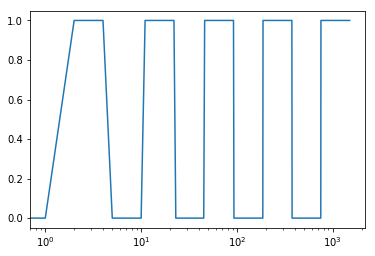

In [32]:
plt.plot(chart[5,:])
plt.semilogx()

In [29]:
from itertools import cycle
zeroone = cycle([0,1])
chart[:,4]

NameError: name 'chart' is not defined

In [34]:
zeroone = cycle([0,1])
chart = np.ones((50,1500))
mid_point = chart.shape[1]/2
while mid_point >0:
    value = next(zeroone)
    chart[:,:int(mid_point)] = value
    mid_point/=2

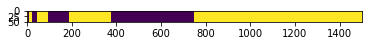

In [35]:
plt.imshow(chart)


In [178]:
import numpy as np
import numexpr as ne

a = np.array([1, 3, 5, 6, 9, 10, 14, 15, 56])
# we define the left and right limit
ll = 6
rl = 10

def sorted_slice(a,l,r):
    start = np.searchsorted(a, l, 'left')
    end = np.searchsorted(a, r, 'right')
    return np.arange(start,end)

answers = [    
sorted_slice(a,ll,rl),
np.where(np.logical_and(a>=ll, a<=rl))[0],
np.where((a >= ll) & (a <=rl))[0],
np.where((a>=ll)*(a<=rl))[0],
np.where(np.vectorize(lambda x: ll <= x <= rl)(a))[0],
np.argwhere((a>=ll) & (a<=rl)).T[0],
np.where(ne.evaluate("(ll <= a) & (a <= rl)"))[0],
]


values = [
   a[np.logical_and(a>=ll, a<=rl)],
   a[(a>=ll) & (a<=rl)],
   a[(a>=ll)*(a<=rl)],
   a[np.vectorize(lambda x: ll <= x <= rl)(a)],
   a[ne.evaluate("(ll <= a) & (a <= rl)")],
]

In [179]:
values

[array([ 6,  9, 10]),
 array([ 6,  9, 10]),
 array([ 6,  9, 10]),
 array([ 6,  9, 10]),
 array([ 6,  9, 10])]

In [187]:
import timeit
setup = """
import numpy as np
import numexpr as ne

a = np.array([1, 3, 5, 6, 9, 10, 14, 15, 56])
# we define the left and right limit
ll = 6
rl = 10

def sorted_slice(a,l,r):
    start = np.searchsorted(a, l, 'left')
    end = np.searchsorted(a, r, 'right')
    return np.arange(start,end)
"""

functions = ['sorted_slice(a,ll,rl)',
'np.where(np.logical_and(a>=ll, a<=rl))[0]',
'np.where((a >= ll) & (a <=rl))[0]',
'np.where((a>=ll)*(a<=rl))[0]',
'np.where(np.vectorize(lambda x: ll <= x <= rl)(a))[0]',
'np.argwhere((a>=ll) & (a<=rl)).T[0]',
'np.where(ne.evaluate("(ll <= a) & (a <= rl)"))[0]',]

functions2 = [
   'a[np.logical_and(a>=ll, a<=rl)]',
   'a[(a>=ll) & (a<=rl)]',
   'a[(a>=ll)*(a<=rl)]',
   'a[np.vectorize(lambda x: ll <= x <= rl)(a)]',
   'a[ne.evaluate("(ll <= a) & (a <= rl)")]',
]

In [188]:
elapsed_times = []
for i in functions:
    print(i)
    elapsed_times.append(timeit.timeit(i,setup=setup,number=100000)) 

sorted_slice(a,ll,rl)
np.where(np.logical_and(a>=ll, a<=rl))[0]
np.where((a >= ll) & (a <=rl))[0]
np.where((a>=ll)*(a<=rl))[0]
np.where(np.vectorize(lambda x: ll <= x <= rl)(a))[0]
np.argwhere((a>=ll) & (a<=rl)).T[0]
np.where(ne.evaluate("(ll <= a) & (a <= rl)"))[0]


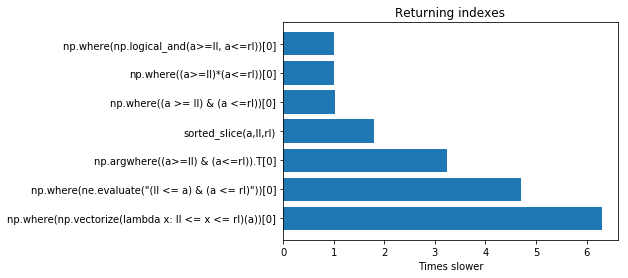

In [189]:
import matplotlib.pyplot as plt

# Example data
sorted_f = [x for _,x in sorted(zip(elapsed_times,functions))]
y_pos = np.arange(len(sorted_f))
fig, ax = plt.subplots()
ax.barh(y_pos, np.array(sorted(elapsed_times))/min(elapsed_times), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Times slower')
ax.set_title('Returning indexes')

plt.show()

In [183]:
elapsed_times2 = []
for i in functions2:
    print(i)
    elapsed_times2.append(timeit.timeit(i,setup=setup,number=100000)) 

a[np.logical_and(a>=ll, a<=rl)]
a[(a>=ll) & (a<=rl)]
a[(a>=ll)*(a<=rl)]
a[np.vectorize(lambda x: ll <= x <= rl)(a)]
a[ne.evaluate("(ll <= a) & (a <= rl)")]


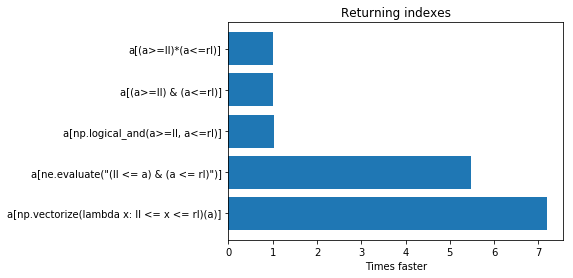

In [185]:
# Example data
sorted_f = [x for _,x in sorted(zip(elapsed_times2,functions2))]
y_pos = np.arange(len(sorted_f))
fig, ax = plt.subplots()
ax.barh(y_pos, np.array(sorted(elapsed_times2))/min(elapsed_times2), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_f)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Times slower')
ax.set_title('Returning indexes')

plt.show()

In [235]:
A = np.ones((4,3))
print(A.shape)
N = 4
A2 = np.c_[ A, np.zeros(N) ] 
print(A2.shape)

(4, 3)
(4, 4)


In [231]:
h = np.c_[derivative,np.zeros(55)]
h.shape

(55, 57)

In [234]:
derivative.shape

(55, 56)

In [236]:
A

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [238]:
np.diff(A,axis=1)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

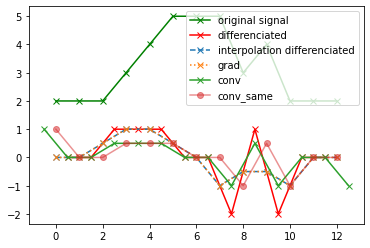

In [234]:
import numpy as np
from scipy.interpolate import interp1d
x = np.arange(len(signal))
signal  = [2,2,2,3,4,5,5,5,3,4,2,2,2]
# classical differentiation
diff = np.diff(signal)

f = interp1d(x, signal,fill_value='extrapolate')
newx = np.arange(-0.5, len(signal)+0.5)
ynew = f(newx)
intdiff = np.diff(ynew)
grad = np.gradient(signal)
conv = np.convolve(signal,[0.5,-0.5])
conv2 = np.convolve(signal,[0.5,-0.5],mode='same')


import matplotlib.pyplot as plt 
plt.plot(x,signal,marker='x',color='g',label='original signal')
plt.plot(x[:-1]+0.5,diff,marker='x',color='r',label='differenciated')
plt.plot(x,intdiff,marker='x',label='interpolation differenciated',linestyle='--')
plt.plot(x,grad,marker='x',label='grad',linestyle=':')
plt.plot(newx,conv,marker='x',label='conv')
plt.plot(conv2,marker='o',alpha=0.5,label='conv_same')
plt.legend()
